In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math
import numpy as np

In [2]:
from gpt.maps import Map2D_E
from gpt.maps import GDFFieldMap

gun = Map2D_E('dcgun', 'fields/gun_0mm.gdf')
?gun

Type:        Map2D_E
String form:
Name: dcgun
Type: Map2D_E
s-entrance: 0 m.
s-exit: 0.15 m.
Length: 0.15
Width: 0.3 m.
File:        ~/Documents/GitHub/lume-gpt/gpt/maps.py
Docstring:   Defines a 2D (r,z), (Er, Ez) cylindrically electric symmetric field map object


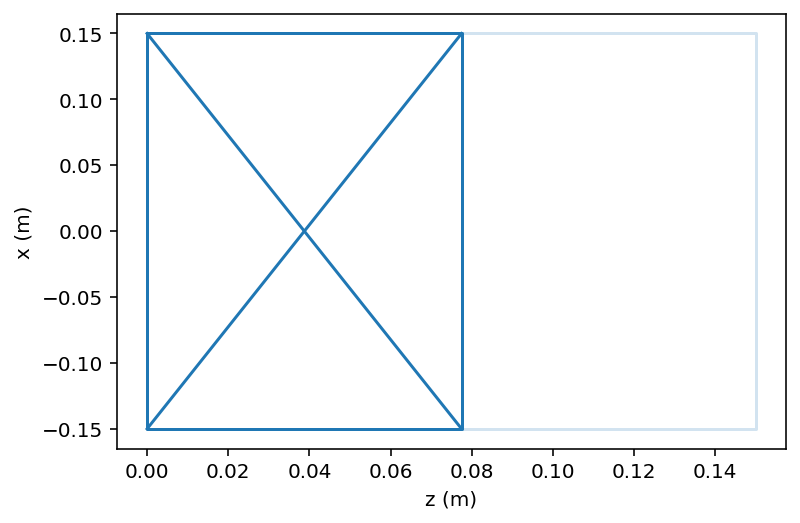

In [3]:
gun.plot_floor();

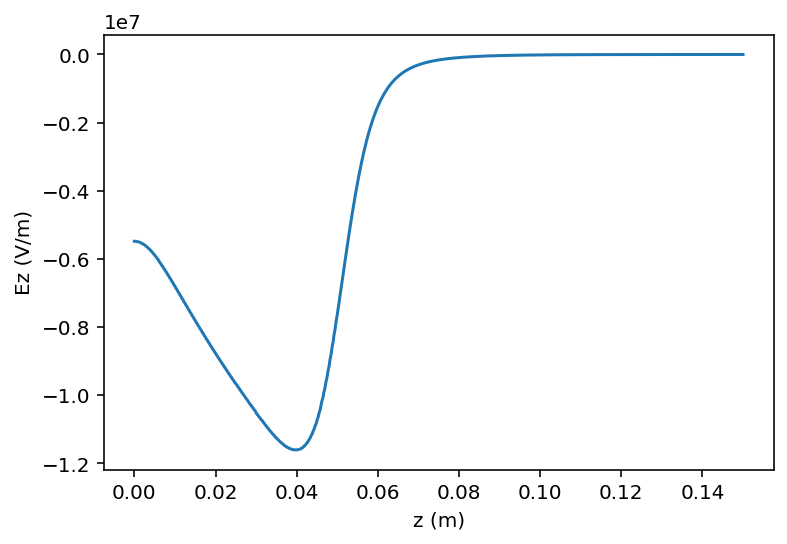

In [4]:
gun.plot_field_profile();

In [5]:
gun.field_integral

-500043.60197424993

In [7]:
for line in gun.gpt_lines(): print(line)

dcgun_x = 0.0;
dcgun_y = 0.0;
dcgun_z = 0.15;
dcgun_scale = 1;
Map2D_E("wcs", dcgun_x, dcgun_y, dcgun_z, 1, 0, 0, 0, 1, 0, "/Users/colwyngulliford/Documents/GitHub/lume-gpt/examples/elements/fields/gun_0mm.gdf", "R", "Z", "Er", "Ez", dcgun_scale);


In [9]:
data = np.zeros( (len(gun.z0),2) )

In [13]:
data[:,0] = gun.z0 + 0.15
data[:,1] = gun.Ez0

In [16]:
np.savetxt('dcgun_GHV_1D.txt', data, header='z Ez')